# Inpainting using a U-net
Here I use a basic U-net architecture to perform inpainting on a masked image. 90% of the pixels in the image are removed, and the network attempts to recreate the original image from this. This is all being done on a CPU, so a small network and image size are used, and training only runs for one epoch.

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.optimizers import *
import numpy as np

In [290]:
def get_model(input_shape = (128,128,3)):
    inputs = tf.keras.Input(shape=(input_shape))
    
    conv1 = Conv2D(16, 3, padding = 'same')(inputs)
    conv1 = LeakyReLU(0.01)(conv1)
    conv1 = Conv2D(16, 3, padding = 'same')(conv1)
    conv1 = LeakyReLU(0.01)(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(32, 3, padding = 'same')(pool1)
    conv2 = LeakyReLU(0.01)(conv2)
    conv2 = Conv2D(32, 3, padding = 'same')(conv2)
    conv2 = LeakyReLU(0.01)(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(64, 3, padding = 'same')(pool2)
    conv3 = LeakyReLU(0.01)(conv3)
    conv3 = Conv2D(64, 3, padding = 'same')(conv3)
    conv3 = LeakyReLU(0.01)(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(128, 3, padding = 'same')(pool3)
    conv4 = LeakyReLU(0.01)(conv4)
    conv4 = Conv2D(128, 3, padding = 'same')(conv4)
    conv4 = LeakyReLU(0.01)(conv4)
    
    up1 = Conv2DTranspose(64, 3, strides=2, padding = 'same')(conv4)
    up1 = LeakyReLU(0.01)(up1)
    merge1 = concatenate([conv3, up1], axis = 3)
    convUp1 = Conv2D(64, 3, padding = 'same')(merge1)
    convUp1 = LeakyReLU(0.01)(convUp1)
    convUp1 = Conv2D(64, 3, padding = 'same')(convUp1)
    convUp1 = LeakyReLU(0.01)(convUp1)
    
    up2 = Conv2DTranspose(32, 3, strides=2, padding = 'same')(convUp1)
    up2 = LeakyReLU(0.01)(up2)
    merge2 = concatenate([conv2, up2], axis = 3)
    convUp2 = Conv2D(32, 3, padding = 'same')(merge2)
    convUp2 = LeakyReLU(0.01)(convUp2)
    convUp2 = Conv2D(32, 3, padding = 'same')(convUp2)
    convUp2 = LeakyReLU(0.01)(convUp2)
    
    up3 = Conv2DTranspose(16, 3, strides=2, padding = 'same')(convUp2)
    up3 = LeakyReLU(0.01)(up3)
    merge3 = concatenate([conv1, up3], axis = 3)
    convUp3 = Conv2D(16, 3, padding = 'same')(merge3)
    convUp3 = LeakyReLU(0.01)(convUp3)
    convUp3 = Conv2D(16, 3, padding = 'same')(convUp3)
    convUp3 = LeakyReLU(0.01)(convUp3)
    
    outs = Conv2D(3, 1, activation=sigmoid)(convUp3)
    
    model = tf.keras.Model(inputs = inputs, outputs = outs)
    return model

In [291]:
model = get_model()

In [292]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 128, 128, 16) 448         input_9[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_128 (LeakyReLU)     (None, 128, 128, 16) 0           conv2d_113[0][0]                 
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 128, 128, 16) 2320        leaky_re_lu_128[0][0]            
____________________________________________________________________________________________

### Generate a mask with a given % of pixels set to 0

In [293]:
im_shape = (128,128)
def generate_mask(percent_masked = 0.9, shape = im_shape):
    num_elements = np.ones(shape).size
    num_masked = int(num_elements*percent_masked)
    mask_indices = np.random.choice(num_elements, num_masked, replace=False)
    mask = np.ones((num_elements))
    mask[mask_indices]=0
    mask = np.reshape(mask,(shape[0],shape[1],1))
    mask = np.concatenate([mask,mask,mask],axis = 2)
    return mask.astype(int)

### Images are resized and masked at the time they are loaded. When training for multiple epochs, this allows for generating many more image pairs than just saving masked images.

In [294]:
import os
from PIL import Image
train_path = 'C:/Users/jvona/Documents/train2017'

def load_data(ids):
    X = []
    Y = []
    
    for i in ids:
        y = Image.open(os.path.join(train_path, i))
        y = np.array(y.resize(im_shape))/255.0
        if len(y.shape)<3:
            y = np.expand_dims(y,2)
            y = np.concatenate([y,y,y],axis=2)
            
        mask = generate_mask()
        x = y*mask
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)

def batch_generator(ids, batch_size = 8):
    batch = []
    while True:
        np.random.shuffle(ids)
        for i in ids:
            batch.append(i)
            if len(batch)==batch_size:
                yield load_data(batch)
                batch = []

In [295]:
model.compile(optimizer=Adam(1e-4),loss = tf.keras.losses.mean_squared_error)

In [296]:
train_names = os.listdir(train_path)
batch_num = 8

In [297]:
model.fit(batch_generator(ids=train_names,batch_size=batch_num),epochs = 1,steps_per_epoch=len(train_names)//batch_num)

  ...
    to  
  ['...']
Train for 14785 steps
14785/14785 [==============================] - 59852s 4s/step - loss: 0.0115


In [264]:
im = Image.open('C:/Users/jvona/Documents/test2017/000000003004.jpg')

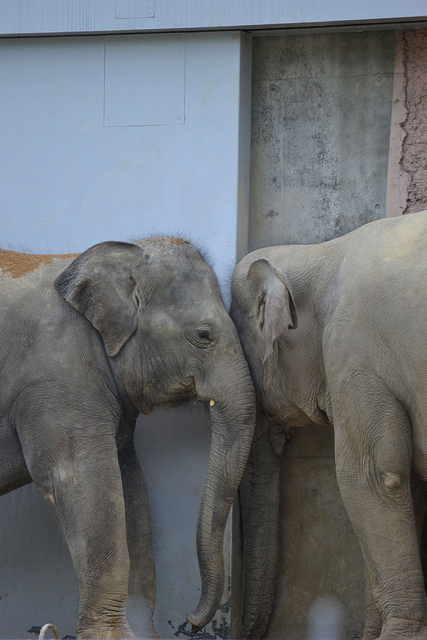

In [265]:
im

In [266]:
im_fixed = np.array(im.resize(im_shape))/255.0

mask = generate_mask()
im_masked = im_fixed*mask

In [267]:
im_masked_fixed = (im_masked*255).astype(np.uint8)
im_masked_fixed = Image.fromarray(im_masked_fixed)

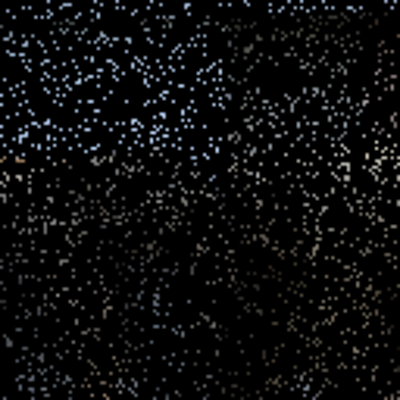

In [268]:
im_masked_fixed.resize((400,400))

In [269]:
predicted = model.predict(np.reshape(im_masked,(1,128,128,3)))
predicted = np.clip(predicted,0.,1.)
predicted = predicted.squeeze()

In [270]:
predicted_fixed = (predicted*255).astype(np.uint8)
predicted_fixed = Image.fromarray(predicted_fixed)

In [262]:
np.min(predicted)

0.019189369

In [276]:
final_img = predicted_fixed.resize(im.size)

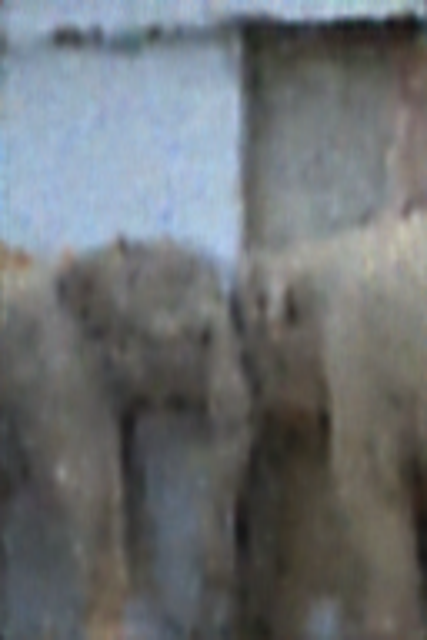

In [277]:
final_img